## LSTM Base

### Data Preparation

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import hvplot.xarray
import sys
import tensorflow as tf

%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer



sys.path.insert(0, '../src')

from utils import df_to_xarray,read_xarray

In [86]:
# Reading Data
dir_name="../data/member_001"
chl,mld,sss,sst,u10,fg_co2,xco2,icefrac,patm,pco2=read_xarray(dir_name)

# Creating one singular df
data_read=xr.merge([mld.MLD,mld.MLD_socat,sst.SST,sst.SST_socat,sss.SSS,sss.SSS_socat,xco2])
tmp_data=data_read.to_dataframe().reset_index()

tmp_data=tmp_data.drop(columns=['bnds','TLONG', 'TLAT', 'time_bnds'])

chl_data=chl.Chl.to_dataframe().reset_index()
chl_data_socat=chl.Chl_socat.to_dataframe().reset_index()
pco2_data=pco2.pCO2.to_dataframe().reset_index()
pco2_data_socat=pco2.pCO2_socat.to_dataframe().reset_index()

tmp_data["Chl_socat"]=chl_data_socat["Chl_socat"]
tmp_data["Chl"]=chl_data["Chl"]
tmp_data["pCO2_socat"]=pco2_data_socat["pCO2_socat"]
tmp_data["pCO2"]=pco2_data["pCO2"]

features_socat = ['time', 'xlon', 'ylat','MLD_socat', 'SST_socat', 'SSS_socat','Chl_socat', 'XCO2','pCO2_socat']
features = ['time', 'xlon', 'ylat','MLD','SST','SSS','Chl','XCO2','pCO2']

# create separate dataframe for socat
combined_socat=tmp_data.loc[:,features_socat]
combined=tmp_data.loc[:,features]

# drop rows where pco2 or pco2_socat == NA
combined_socat.dropna(subset = ["pCO2_socat"], inplace=True)
combined_socat= combined_socat[combined_socat['pCO2_socat']!=0]
combined.dropna(subset = ["pCO2"], inplace=True)
combined= combined[combined['pCO2']!=0]




In [34]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

((171903, 6), (73673, 6))

In [87]:
X_socat=combined_socat.iloc[:,3:-1]
X=combined.iloc[:,3:-1]
y=combined.loc[:,'pCO2']
y_socat=combined_socat.loc[:,'pCO2_socat']

In [89]:
X_socat=num_pipeline.fit_transform(X_socat)
X=num_pipeline.fit_transform(X)

In [122]:
def custom_train_test_split(X_data, y_data, start, end, window, horizon):
    X,y=[],[]
    start=start+window
    if end == None:
        end= len(X)-horizon
    for i in range(start, end):
        X.append(X_data[i-window:i])
        y.append(y_data[i+1: i+1+horizon])
    return np.array(X), np.array(y) 


In [110]:
len(X)*0.7

12103329.0

In [ ]:
hist_window = 4
horizon = 4
TRAIN_SPLIT = int(len(X)*0.7)

x_train, y_train = custom_train_test_split(X_socat, y_socat, 0, TRAIN_SPLIT, hist_window, horizon)
x_vali, y_vali = custom_train_test_split(X_socat, y_socat, TRAIN_SPLIT, None, hist_window, horizon) 

In [ ]:
x_train

In [ ]:
print ('Multiple window of past history\n')
print(x_train[0])
print ('\n Target horizon\n')
print (y_train[0]) 

In [62]:
batch_size = 256
buffer_size = 150
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()
val_data = tf.data.Dataset.from_tensor_slices((x_vali, y_vali))
val_data = val_data.batch(batch_size).repeat

In [65]:
lstm_model = tf.keras.models.Sequential([
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, return_sequences=True), 
                                input_shape=x_train.shape[-2:]),
     tf.keras.layers.Dense(20, activation='tanh'),
     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150)),
     tf.keras.layers.Dense(20, activation='tanh'),
     tf.keras.layers.Dense(20, activation='tanh'),
     tf.keras.layers.Dropout(0.25),
     tf.keras.layers.Dense(units=horizon),
 ])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.summary() 

In [ ]:
model_path = 'Bidirectional_LSTM_Multivariate.h5'
early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint] 


In [ ]:
history = lstm_model.fit(train_data,epochs=150,steps_per_epoch=30,validation_data=val_data,validation_steps=50,verbose=1,callbacks=callbacks)

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show() 

In [70]:
n_past=4
n_features=6
n_future=1

Tried

In [71]:
# E1D1
# n_features ==> no of features at each timestep in the data.
#



encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)

encoder_states1 = encoder_outputs1[1:]

#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])

#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)

#
model_e1d1 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)

#
model_e1d1.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 4, 6)]       0                                            
__________________________________________________________________________________________________
lstm_9 (LSTM)                   [(None, 100), (None, 42800       input_5[0][0]                    
__________________________________________________________________________________________________
repeat_vector_3 (RepeatVector)  (None, 1, 100)       0           lstm_9[0][0]                     
__________________________________________________________________________________________________
lstm_10 (LSTM)                  (None, 1, 100)       80400       repeat_vector_3[0][0]            
                                                                 lstm_9[0][1]               

In [72]:
# E2D2: two encode/ decode layer
# n_features ==> no of features at each timestep in the data.
#
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]
#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)
#
model_e2d2 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)
#
model_e2d2.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 4, 6)]       0                                            
__________________________________________________________________________________________________
lstm_11 (LSTM)                  [(None, 4, 100), (No 42800       input_6[0][0]                    
__________________________________________________________________________________________________
lstm_12 (LSTM)                  [(None, 100), (None, 80400       lstm_11[0][0]                    
__________________________________________________________________________________________________
repeat_vector_4 (RepeatVector)  (None, 1, 100)       0           lstm_12[0][0]                    
____________________________________________________________________________________________

In [73]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)

model_e1d1.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e1d1=model_e1d1.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=0,callbacks=[reduce_lr])


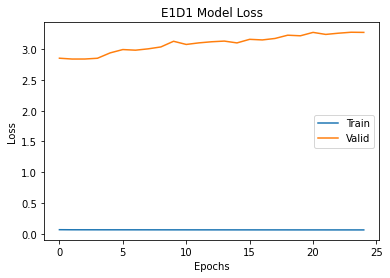

In [74]:
plt.plot(history_e1d1.history['loss'])
plt.plot(history_e1d1.history['val_loss'])
plt.title("E1D1 Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Valid'])
plt.show()

In [69]:
model_e2d2.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2=model_e2d2.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=0,callbacks=[reduce_lr])

ValueError: in user code:

    /Users/shaunkim/Desktop/Columbia/GentineLab/venv/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:855 train_function  *
        return step_function(self, iterator)
    /Users/shaunkim/Desktop/Columbia/GentineLab/venv/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:845 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/shaunkim/Desktop/Columbia/GentineLab/venv/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/shaunkim/Desktop/Columbia/GentineLab/venv/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/shaunkim/Desktop/Columbia/GentineLab/venv/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/shaunkim/Desktop/Columbia/GentineLab/venv/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:838 run_step  **
        outputs = model.train_step(data)
    /Users/shaunkim/Desktop/Columbia/GentineLab/venv/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:795 train_step
        y_pred = self(x, training=True)
    /Users/shaunkim/Desktop/Columbia/GentineLab/venv/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:1013 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /Users/shaunkim/Desktop/Columbia/GentineLab/venv/lib/python3.9/site-packages/tensorflow/python/keras/engine/input_spec.py:267 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer model_1: expected shape=(None, 4, 5), found shape=(None, 4, 6)


In [ ]:
plt.plot(history_e2d2.history['loss'])
plt.plot(history_e2d2.history['val_loss'])
plt.title("E2D2 Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Valid'])
plt.show()

In [75]:
pred_e1d1=model_e1d1.predict(X_test)


In [ ]:
pred_e2d2=model_e2d2.predict(X_test)

In [78]:
pred_e1d1.shape

(73669, 1, 6)

In [79]:
y_test

array([[[-8.41802488, -8.41802488, -8.41802488, -8.41109658,
          0.98165333, -1.26044213]],

       [[-8.41802488, -8.41802488, -8.41802488, -8.41019239,
          0.98165333, -1.29601417]],

       [[ 0.04978183,  0.04978183,  0.04978183, -8.41083497,
          0.98165333, -1.3105747 ]],

       ...,

       [[-8.41802488, -8.41802488, -8.41802488, -8.41376444,
          1.31878042,  0.56410429]],

       [[-8.41802488, -8.41802488, -8.41802488, -8.41291375,
          1.31878042,  0.43627322]],

       [[-8.41802488, -8.41802488, -8.41802488, -8.41290555,
          1.31878042,  0.55213852]]])